## To-do list
- metrics functions
- check for directories structure (model for prediction, databases, saving directory for the drawdown/VaR/etc plots, backup directory for model, backup directory for plots)
- import metrics (VaR, cVaR, drawdown, etc.) functions from metrics module
- functions module maybe?
- Binance access and etc (copy from Touring)
- Copy keys.py explanation from Touring
- Two main fund strategies: (1) passive - trade on 1st of each month, keep in basked the 10 crytpos with the most market cap; (2) active - trade every week based on predicted returns for the next week
- Let the user define how many assets to invest into
- Tem que usar sentiment analysis de twitter, reddit, google news, etc. Trabalhar com dados em T+0 e em T-1, T-2, T-3...
- Faz defasagem para RSI também
- Ver se tem algum dado de taxa de juros americana/europeia/chinesa(?)/japonesa diária
- Ou algum dado 'mundial' para ajudar na intepretação dos dados
- Também trabalhar com defasagens (1, 2, 3...) nesses dados
- When using Markovwitz, use pypfopt package


In [1]:
#------ Import basic packages
#import matplotlib.pyplot as plt
#import seaborn as sns
#import smtplib  # Needed for the e-mail reports
#import binance.enums  # Responsible for trading

import numpy as np
import pandas as pd
#import pandas_ta
from functions import *
pd.set_option('display.float_format', lambda x: '%.8f' % x)

In [2]:
#from metrics import mvcriterion, optim_mvcrit

#wallet = binance_wallet()

# fetch_data() checks for the most liquid cryptos and fetches the data from Binance
data = fetch_data(days=365*2, interval='1d')
#data.drop('cluster_num', axis=1, inplace=True)

# Let's calculate the technical indicators
data = estimate_indicators(data, rsi=20, bbands=20, roll=13)

# After the indicators are calculated, perform the normalization of the values
normalized_close = data.groupby(level='asset')['close'].apply(lambda x:
                                                              np.subtract(x, data.groupby(level='asset')['close'].mean())/data.groupby(level='asset')['close'].std()
                                                              )

# Register the normalized close into the df
data['close_norm'] = np.array(normalized_close)

# Now we need to estimate the optimal number of clusters to
# allocate our resources
clust = estimate_kmeans(data.drop('close', axis=1), cutoff=0.25)

# Sets the params for the clustering function used with apply below
params2 = {'clusters':clust,
           'means':1}

# Groups the data and applies the clustering
data = data.dropna().groupby('time', group_keys=False).apply(clustering, **params2)

Checking for trading pairs...
The resources directory exists, checking for trade pairs file.
Trading pairs file 'pairs_202508.csv' found, checking version.
Trading pairs file is up to date.
Loading pairs.
Pairs successfully loaded.
Requesting informations from Binance.
Request successful. Splitting data...
All done.
Requesting informations from Binance.
Request successful. Splitting data...
All done.
Requesting informations from Binance.
Request successful. Splitting data...
All done.
Requesting informations from Binance.
Request successful. Splitting data...
All done.
Requesting informations from Binance.
Request successful. Splitting data...
All done.
Requesting informations from Binance.
Request successful. Splitting data...
All done.
Requesting informations from Binance.
Request successful. Splitting data...
All done.
Requesting informations from Binance.
Request successful. Splitting data...
All done.
Requesting informations from Binance.
Request successful. Splitting data...
All 

/home/thiago/.pyenv/versions/3.12.3/lib/python3.12/site-packages/pandas_ta/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


Calculating dollar volume in millions.
Aggregating data to bi-weekly periods, filtering best cryptos.
Creating dollar volume moving averages.
Checking cryptos liquidity.
Creating a rank for the best cryptos in the dataset.
Estimating returns.
All indicators successfuly calculated.


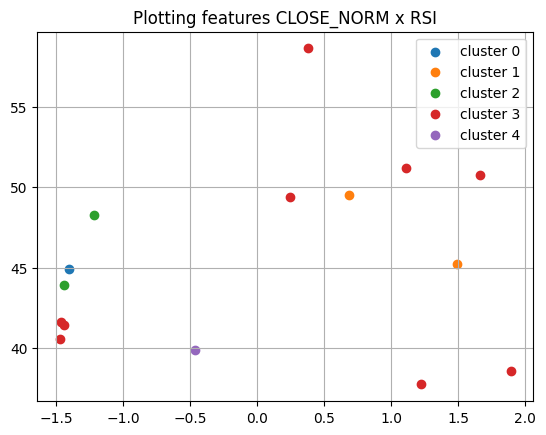

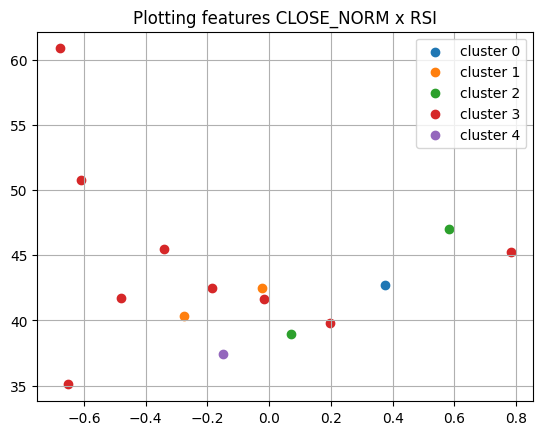

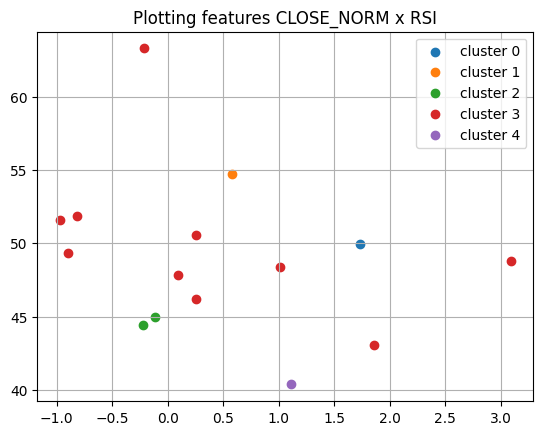

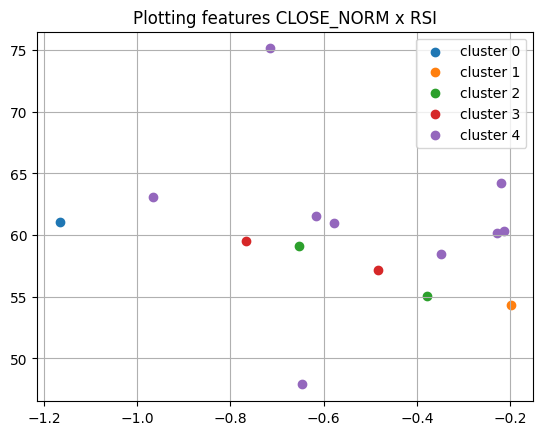

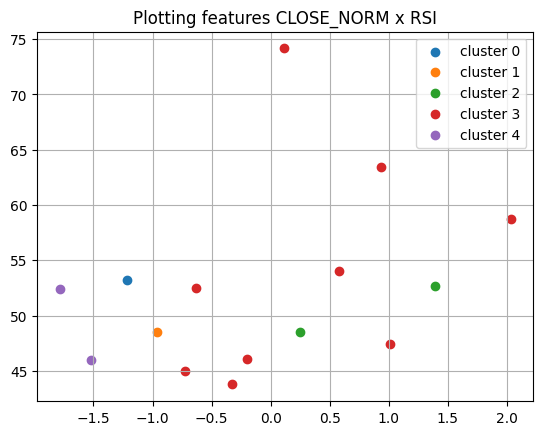

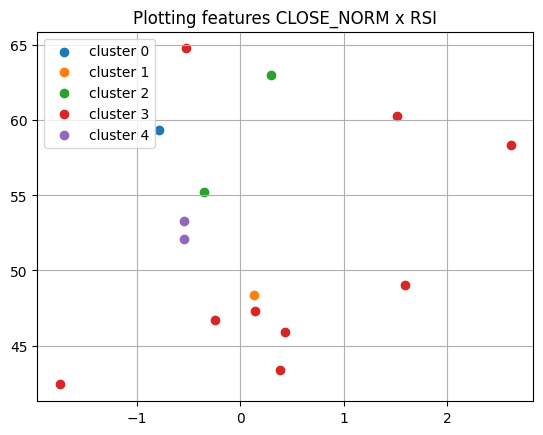

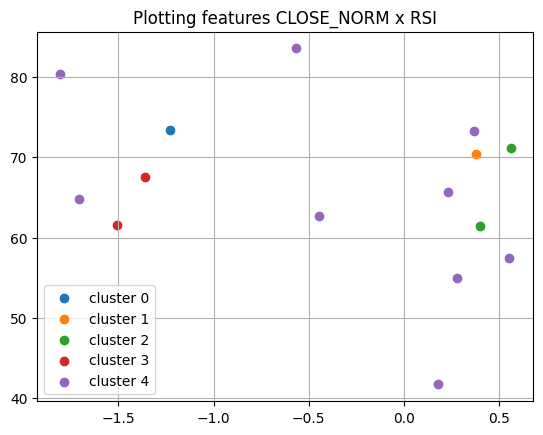

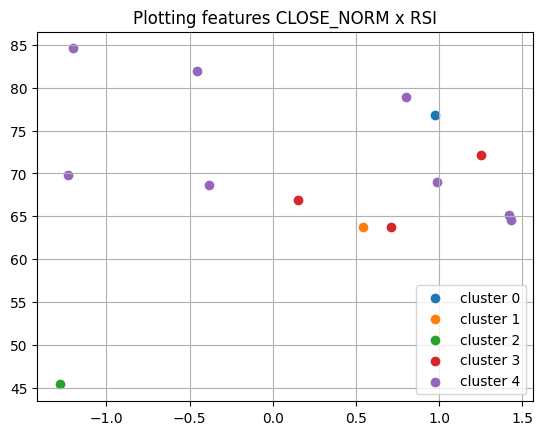

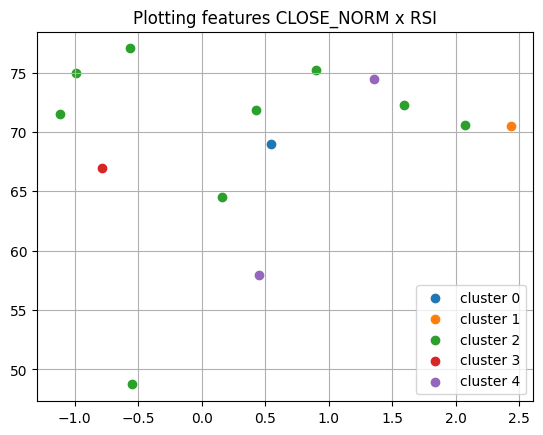

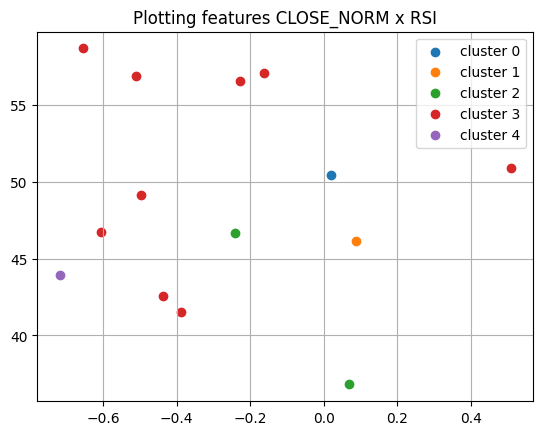

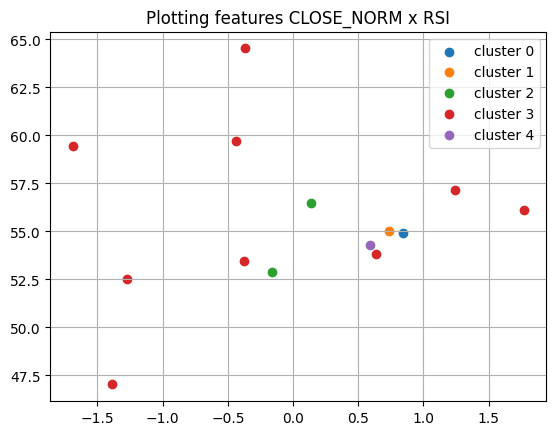

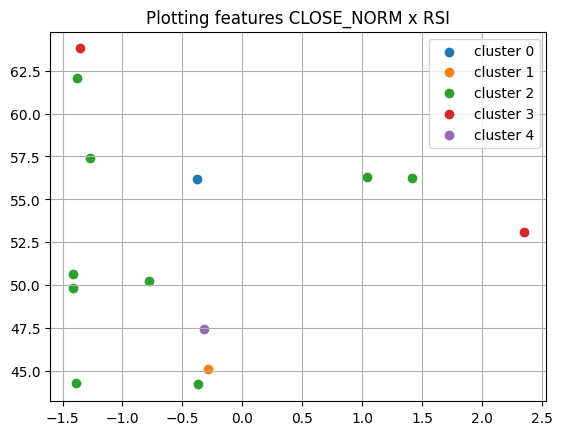

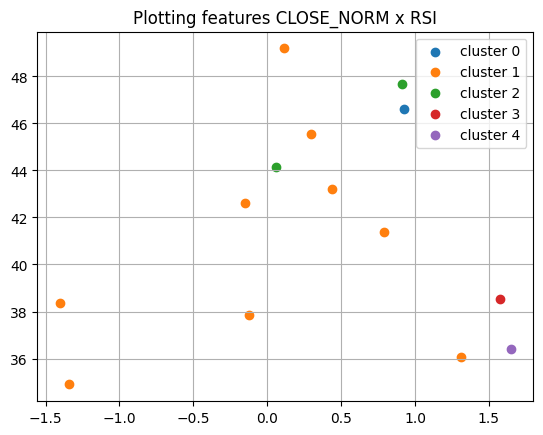

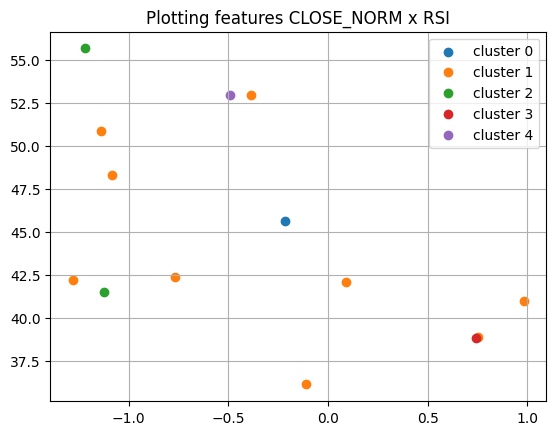

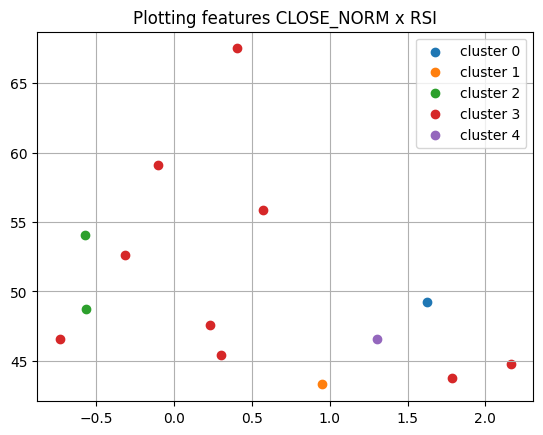

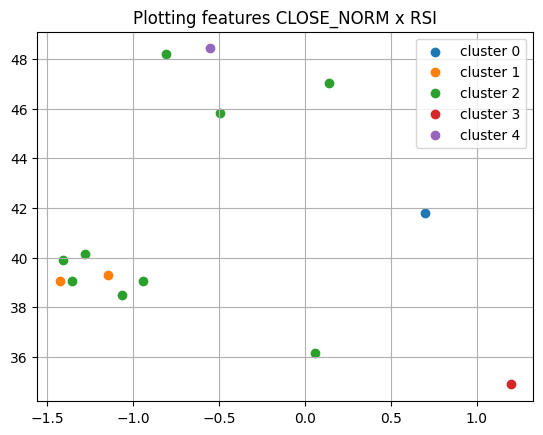

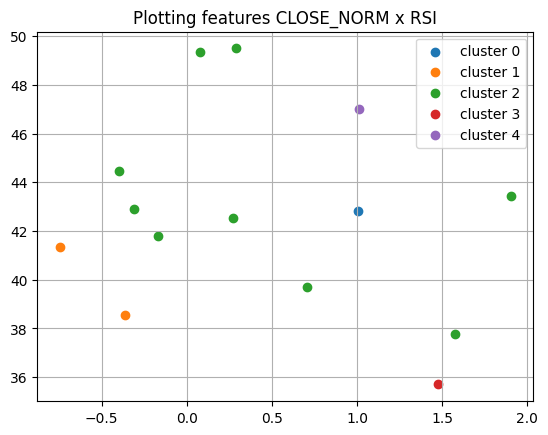

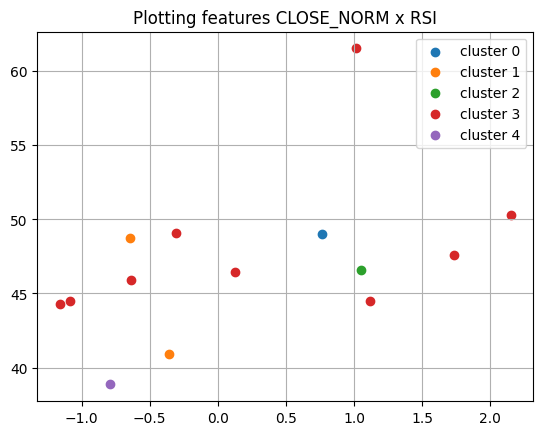

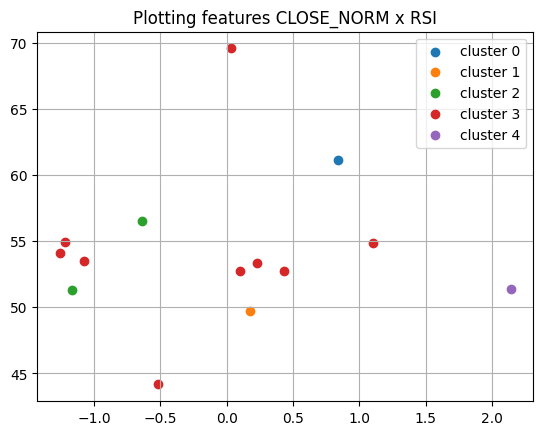

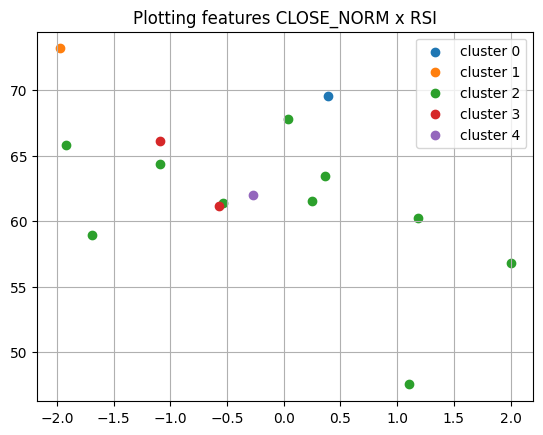

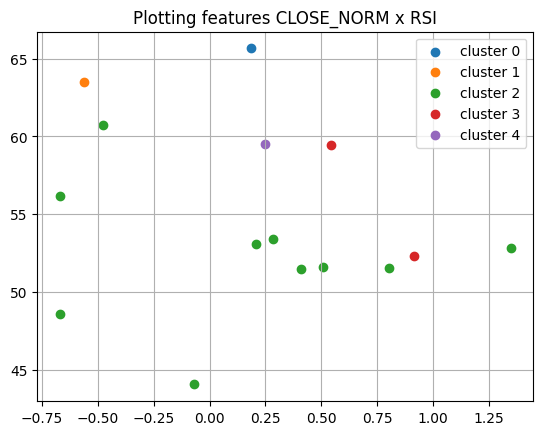

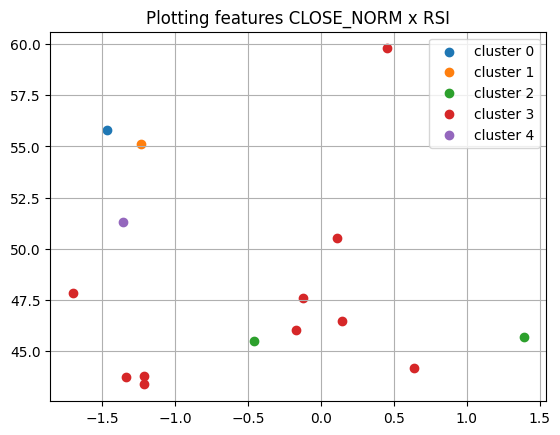

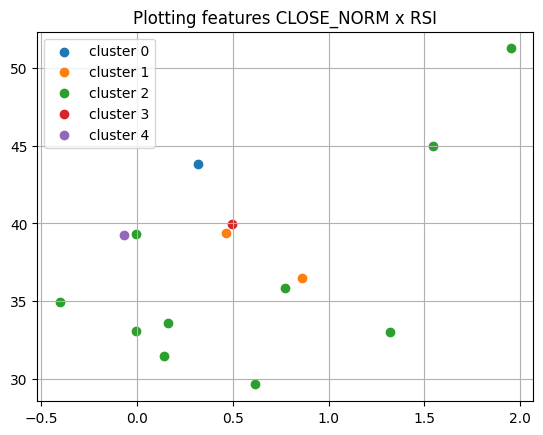

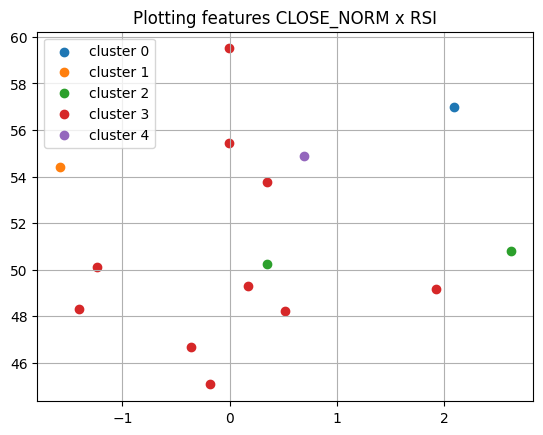

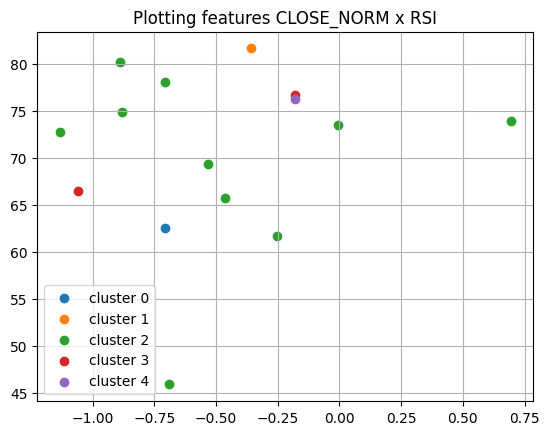

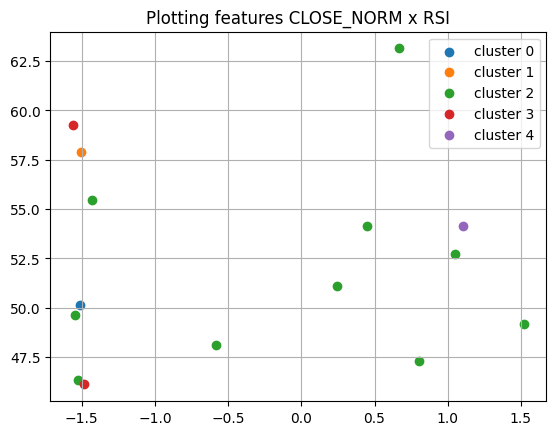

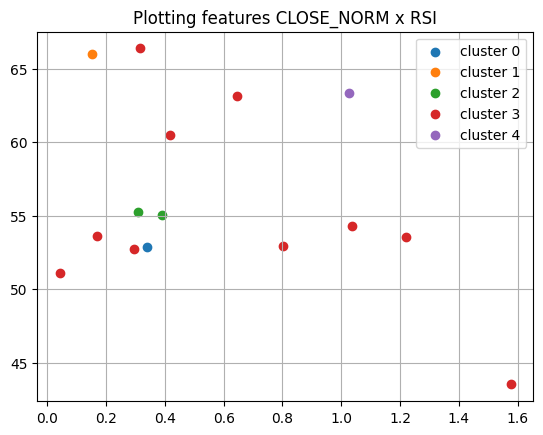

In [5]:
# Prints the clustering graph
for i in data.index.get_level_values('time').unique().to_list():
    g = data.xs(i, level=0)
    plot_clusters(g, attr_1='close_norm', attr_2='rsi')

### Down here are the tweaked functions:

In [5]:
#------ Normalizer
def normalizer(df, feat='close'):
    """
    Description: performs the normalizing of the data values using scipy.

    Input: pd.Series, the data to perform the normalization process;
            feat (str), the feature (column) with the values to be normalized. Defaults to 'close'.
            
    Output: pd.Series, the normalized feature
    """
    import pandas as pd
    from scipy import stats
    
    # First we record the mean and std in case we need to return the values to
    # their original state

    # Calculates the mean
    feat_mean = df.groupby(level='asset')[feat].mean()
    feat_mean.name = 'Mean'

    # Calculates de standard deviation
    feat_std = df.groupby(level='asset')[feat].std()
    feat_std.name = 'Std'

    # Stores mean and standard deviation values
    bases = pd.concat([feat_mean, feat_std], axis=1)

    # Once the mean and standard deviation are recorded, we normalize the feature
    try:
        print('Iniciando processo de normalização.\n')
        temp = stats.zscore(df[feat])
        print('Processo de normalização concluído com sucesso!')
    except Exception as e:
        print(f'O seguinte erro ocorreu durante a tentativa de padronização por ZScore: {e}. Favor verificar')
    
    return temp, bases


In [3]:
data

close         rsi      bb_low      bb_mid  \
time       asset                                                         
2024-08-18 ADAUSDT      0.33420000 41.59918841  0.26296912  0.29755875   
           AVAXUSDT    20.82000000 40.57052856  2.96337902  3.12683054   
           BCHUSDT    333.10000000 43.90950559  5.68437378  5.86408055   
           BNBUSDT    531.20000000 48.26183148  6.14220871  6.26003779   
           BTCUSDT  58427.35000000 44.89592325 10.89617304 10.99815513   
...                            ...         ...         ...         ...   
2025-08-17 SUIUSDT      3.70240000 51.09889898  1.46654386  1.54617519   
           TRXUSDT      0.35150000 66.38134353  0.27362533  0.29117478   
           USDCUSDT     0.99930000 43.51148604  0.69274158  0.69303466   
           XLMUSDT      0.42560000 54.28625403  0.31744397  0.35049951   
           XRPUSDT      3.11930000 53.57964279  1.34524716  1.41094294   

                        bb_high         atr        macd   return_1m  \
time       asset                                                      
2024-08-18 ADAUSDT   0.33214838 -0.76818205 -0.59377779 -0.13523512   
           AVAXUSDT  3.29028207 -0.49216615 -0.88724196 -0.20133383   
           BCHUSDT   6.04378731  0.07199782 -0.82719105 -0.08892792   
           BNBUSDT   6.37786686  0.43296572 -0.98508615 -0.06103261   
           BTCUSDT  11.10013722  0.33134804 -1.10145987 -0.07418057   
...                         ...         ...         ...         ...   
2025-08-17 SUIUSDT   1.62580652  0.74855338  0.10460724 -0.02453643   
           TRXUSDT   0.30872424  0.47915097  1.65296262  0.05802966   
           USDCUSDT  0.69332775 -0.41730656 -0.61630316 -0.00005003   
           XLMUSDT   0.38355506  1.04761126  0.45501281 -0.04072099   
           XRPUSDT   1.47663872  1.30695070  0.31166280 -0.04968539   

                      return_2m   return_3m   return_4m   return_5m  \
time       asset                                                      
2024-08-18 ADAUSDT  -0.03159792 -0.05120069 -0.03922723 -0.06437325   
           AVAXUSDT -0.04556795 -0.09039912 -0.05929139 -0.09100715   
           BCHUSDT  -0.03309474 -0.06037432 -0.04225063 -0.06781528   
           BNBUSDT  -0.02067573 -0.02014831 -0.01514961 -0.01320167   
           BTCUSDT  -0.01947746 -0.02617819 -0.00960751 -0.01917400   
...                         ...         ...         ...         ...   
2025-08-17 SUIUSDT   0.10879555  0.00466226  0.00498169  0.04643880   
           TRXUSDT   0.07469735  0.04346915  0.04593897  0.04246734   
           USDCUSDT -0.00010005 -0.00003335 -0.00003752 -0.00008002   
           XLMUSDT   0.16473814  0.06737855  0.05181969  0.04755213   
           XRPUSDT   0.11513397  0.04894886  0.04156432  0.03854972   

                      return_6m  close_norm  cluster_num  
time       asset                                          
2024-08-18 ADAUSDT  -0.06221926 -1.46141271            3  
           AVAXUSDT -0.05787993 -1.47350316            3  
           BCHUSDT  -0.02836925 -1.44464209            2  
           BNBUSDT   0.02088728 -1.21453362            2  
           BTCUSDT  -0.00640921 -1.40525064            0  
...                         ...         ...          ...  
2025-08-17 SUIUSDT   0.01239821  0.04248553            3  
           TRXUSDT   0.03085234  0.31343016            3  
           USDCUSDT -0.00005002  1.57694847            3  
           XLMUSDT   0.01616500  1.03655437            3  
           XRPUSDT   0.00495684  1.21949807            3  

[393 rows x 15 columns]

In [11]:
data.xs('BTCUSDT', level=1)['close'].mean()

np.float64(90893.72703703704)

In [ ]:
data['close_norm'] = np.array(normalized_close)

In [24]:
data

close         rsi      bb_low      bb_mid  \
time       asset                                                         
2024-08-18 ADAUSDT      0.33420000 41.59918841  0.26296912  0.29755875   
           AVAXUSDT    20.82000000 40.57052856  2.96337902  3.12683054   
           BCHUSDT    333.10000000 43.90950559  5.68437378  5.86408055   
           BNBUSDT    531.20000000 48.26183148  6.14220871  6.26003779   
           BTCUSDT  58427.35000000 44.89592325 10.89617304 10.99815513   
...                            ...         ...         ...         ...   
2025-08-17 SUIUSDT      3.70820000 51.20972698  1.46659780  1.54623682   
           TRXUSDT      0.35160000 66.46185709  0.27362054  0.29117848   
           USDCUSDT     0.99930000 43.51148604  0.69274158  0.69303466   
           XLMUSDT      0.42620000 54.40703947  0.31745408  0.35052055   
           XRPUSDT      3.13000000 53.87281538  1.34532972  1.41107265   

                        bb_high         atr        macd   return_1m  \
time       asset                                                      
2024-08-18 ADAUSDT   0.33214838 -0.76818205 -0.59377791 -0.13523512   
           AVAXUSDT  3.29028207 -0.49216615 -0.88724042 -0.20133383   
           BCHUSDT   6.04378731  0.07199782 -0.82719125 -0.08892792   
           BNBUSDT   6.37786686  0.43296572 -0.98508827 -0.06103261   
           BTCUSDT  11.10013722  0.33134804 -1.10145719 -0.07418057   
...                         ...         ...         ...         ...   
2025-08-17 SUIUSDT   1.62587584  0.74855338  0.10770203 -0.02377268   
           TRXUSDT   0.30873643  0.47915097  1.65444247  0.05818015   
           USDCUSDT  0.69332775 -0.41730656 -0.61630316 -0.00005003   
           XLMUSDT   0.38358703  1.04761126  0.45759081 -0.04004505   
           XRPUSDT   1.47681558  1.30695070  0.32125016 -0.04805687   

                      return_2m   return_3m   return_4m   return_5m  \
time       asset                                                      
2024-08-18 ADAUSDT  -0.03159792 -0.05120069 -0.03922723 -0.06437325   
           AVAXUSDT -0.04556795 -0.09039912 -0.05929139 -0.09100715   
           BCHUSDT  -0.03309474 -0.06037432 -0.04225063 -0.06781528   
           BNBUSDT  -0.02067573 -0.02014831 -0.01514961 -0.01320167   
           BTCUSDT  -0.01947746 -0.02617819 -0.00960751 -0.01917400   
...                         ...         ...         ...         ...   
2025-08-17 SUIUSDT   0.10922954  0.00492440  0.00517835  0.04660262   
           TRXUSDT   0.07477378  0.04351862  0.04597617  0.04249699   
           USDCUSDT -0.00010005 -0.00003335 -0.00003752 -0.00008002   
           XLMUSDT   0.16512157  0.06762920  0.05200493  0.04769337   
           XRPUSDT   0.11608904  0.04954770  0.04201026  0.03890542   

                      return_6m  cluster_num  close_norm  
time       asset                                          
2024-08-18 ADAUSDT  -0.06221926            3 -1.46140999  
           AVAXUSDT -0.05787993            3 -1.47350030  
           BCHUSDT  -0.02836925            2 -1.44463957  
           BNBUSDT   0.02088728            2 -1.21453380  
           BTCUSDT  -0.00640921            0 -1.40524859  
...                         ...          ...         ...  
2025-08-17 SUIUSDT   0.01253028            3  0.04203967  
           TRXUSDT   0.03087678            3  0.31283854  
           USDCUSDT -0.00005002            3  1.57567712  
           XLMUSDT   0.01628430            3  1.03557373  
           XRPUSDT   0.00524366            3  1.22984017  

[393 rows x 15 columns]